# Tree Crown Detection

The delineation of individual trees in remote sensing images is an key task in forest analysis. As part of Sebastian Hickman's AI4ER MRes project, titled 'Detecting changes in tall tree height with machine learning, LiDAR, and RGB imagery', the authors propose the `detectreeRGB` model, an implementation of Mask R-CNN from [Detectron2](https://github.com/facebookresearch/detectron2) to perform tree crown delineation from RGB imagery.

<img src="https://github.com/shmh40/detectreeRGB/blob/main/imgs/plot_13_285520_583300.jpg?raw=true" width="400">

**Figure 1** Example image of the predictions made by Mask R-CNN. Source: [Hickman et al. (2021)](https://github.com/shmh40/detectreeRGB).

<div class="alert alert-block alert-info">
     <p>   
        In this notebook, we'll walk through how scivision can assist in discovering a pretrained detectreeRGB model provided by Hickman et al (2021), and then use it to delineate crowns from a sample drone RGB image dataset.
    </p> 
    <p>    
    Further details of the detectreeRGB can be found in 
        <a href="https://github.com/shmh40/detectreeRGB/"> the original model repository</a>.
    </p>     
</div>

## Load libraries

In [1]:
!pip install opencv-python-headless #hide only if the notebook runs in standard desktop environments

  Using cached opencv_python_headless-4.7.0.68-cp37-abi3-macosx_10_13_x86_64.whl (51.7 MB)


In [2]:
from scivision.catalog import default_catalog
from scivision.io import load_dataset, load_pretrained_model
from intake_zenodo_fetcher import download_zenodo_files_for_entry

/Users/ifenton/opt/anaconda3/envs/treecrown-detection_detectreeRGB/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Catalog
We'll use the detectreeRGB model which is registered in the `scivision` model catalog as `detectreeRGB-forest`. Then we'll look with compatible_datasources potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [3]:
model_name = 'detectreeRGB-forest'

In [4]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [5]:
compatible_datasources

,name,description,tasks,labels_provided,domains,url,format,institution,tags
0,stardist-cell-nuclei-2D,Cell microscopy test dataset for detection and...,"(TaskEnum.segmentation, TaskEnum.object_detect...",True,"(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,oppd-seedlings,The Open Plant Phenotyping Database [OPPD] is ...,"(TaskEnum.thresholding, TaskEnum.segmentation,...",True,"(multispectral, hyperspectral)",https://github.com/alan-turing-institute/oppd-...,image,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
2,scivision-test-data,Test data comprised of individual images inclu...,"(TaskEnum.classificiation, TaskEnum.object_det...",True,"(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,"(Wikipedia by Erik Veland,)","(demo,)"
4,coastal-edges,Sample dataset of satellite RGB imagery over t...,"(TaskEnum.classificiation, TaskEnum.segmentation)",False,"(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."
5,treecrowns,Sample dataset of drone RGB imagery over Sepil...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(computer-vision, earth-observation, ecology)",https://github.com/shmh40/detectreeRGB-treecro...,image,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."
6,sentinel2_stac,Data plugin for accessing Sentinel-2 Cloud-Opt...,"(TaskEnum.classificiation, TaskEnum.segmentation)",False,"(computer-vision, earth-observation, ecology)",https://github.com/alan-turing-institute/scivi...,image,"(The Alan Turing Institute,)","(satellite, aerial, remote-sensing, ecology, e..."
9,Parakeet,Synthetic cryoEM data from Parakeet,"(TaskEnum.object_detection, TaskEnum.classific...",False,None,https://github.com/rosalindfranklininstitute/s...,image,"(Rosalind Franklin Institute,)","(CryoEM,)"


## Model
The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [6]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

  Cloning https://github.com/acocac/detectreeRGB-treecrown-scivision (to revision main) to /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-install-cq_bl8z7/detectreergb-treecrown-scivision_0967797909d34306bad5e64c1a5118d4


  Running command git clone --filter=blob:none --quiet https://github.com/acocac/detectreeRGB-treecrown-scivision /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-install-cq_bl8z7/detectreergb-treecrown-scivision_0967797909d34306bad5e64c1a5118d4


  Resolved https://github.com/acocac/detectreeRGB-treecrown-scivision to commit 5819984c0a7fa94e9012265045c272266dc8fef3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-install-cq_bl8z7/detectron2_9c58b9acedde442995f8a51bf01faaa3


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-install-cq_bl8z7/detectron2_9c58b9acedde442995f8a51bf01faaa3
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464


  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 MB 9.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 9.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiohttp 3.8.3 requires charset-normalizer<3.0,>=2.0, but you have charset-normalizer 3.0.1 which is incompatible.


In [7]:
model

scivision.PretrainedModel( 
  module='detectreeRGB_treecrown_scivision', 
  model='DetectreeRGB', 
  source='https://github.com/acocac/detectreeRGB-treecrown-scivision' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in compatible_datasources. In this case, we will use the dataset registered with the name field equals to `data-006`. This refers to a drone image dataset kindly shared by Hickman et al. in a [zenodo repository](https://zenodo.org/record/5090039#.Ys_rxC8w1pQ) to demonstrate the `detectreeRGB` model.

In [8]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'treecrowns']
target_datasource

,name,description,tasks,labels_provided,domains,url,format,institution,tags
5,treecrowns,Sample dataset of drone RGB imagery over Sepil...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(computer-vision, earth-observation, ecology)",https://github.com/shmh40/detectreeRGB-treecro...,image,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


In [9]:
cat = load_dataset(target_datasource.url.item()) 
download_zenodo_files_for_entry(cat.sepilok_rgb, force_download=False)
dataset = cat.sepilok_rgb().to_dask()

In dataset, the sample image, which actually has an RGB bands plus additional band, is loaded into single `xarray.Dataset` object with a defined dimension, in this case 1400 px x 1400 px. 

In [10]:
dataset

<xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        ...,
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ]]], dtype=float32)
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 6.467e+05 6.467e+05 6.467e+05 ... 6.466e+05 6.466e+05
  * x        (x) float64 6.025e+05 6.025e+05 6.025e+05 ... 6.026e+05 6.026e+05
Attributes:
    transform:      (0.1, 0.0, 602480.0, 0.0, -0.1, 646720.0)
    crs:            +init=epsg:32650
    res:            (0.1, 0.1)
    is_tiled:       0
    nodatavals:     (-3.3999999521443642e+38, -3.3999999521443642e+38, -3.399...
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Prediction and visualisation
Once we load model and data, we will use the predict function previously defined within the scivision configuration file of the model. In this example, the predict function goes over the RGB bands of the image and we enable the `plot` argument to plot the predictions over the drone RGB image. If we set `plot=False`, it will only return the instance values which can be then plotted as it is indicated in the example of detectreeRGB in the Environmental Data Science book (see [here](https://the-environmental-ds-book.netlify.app/gallery/modelling/forest-modelling-treecrown_detectreergb/forest-modelling-treecrown_detectreergb#showing-the-predictions-from-detectreergb)).

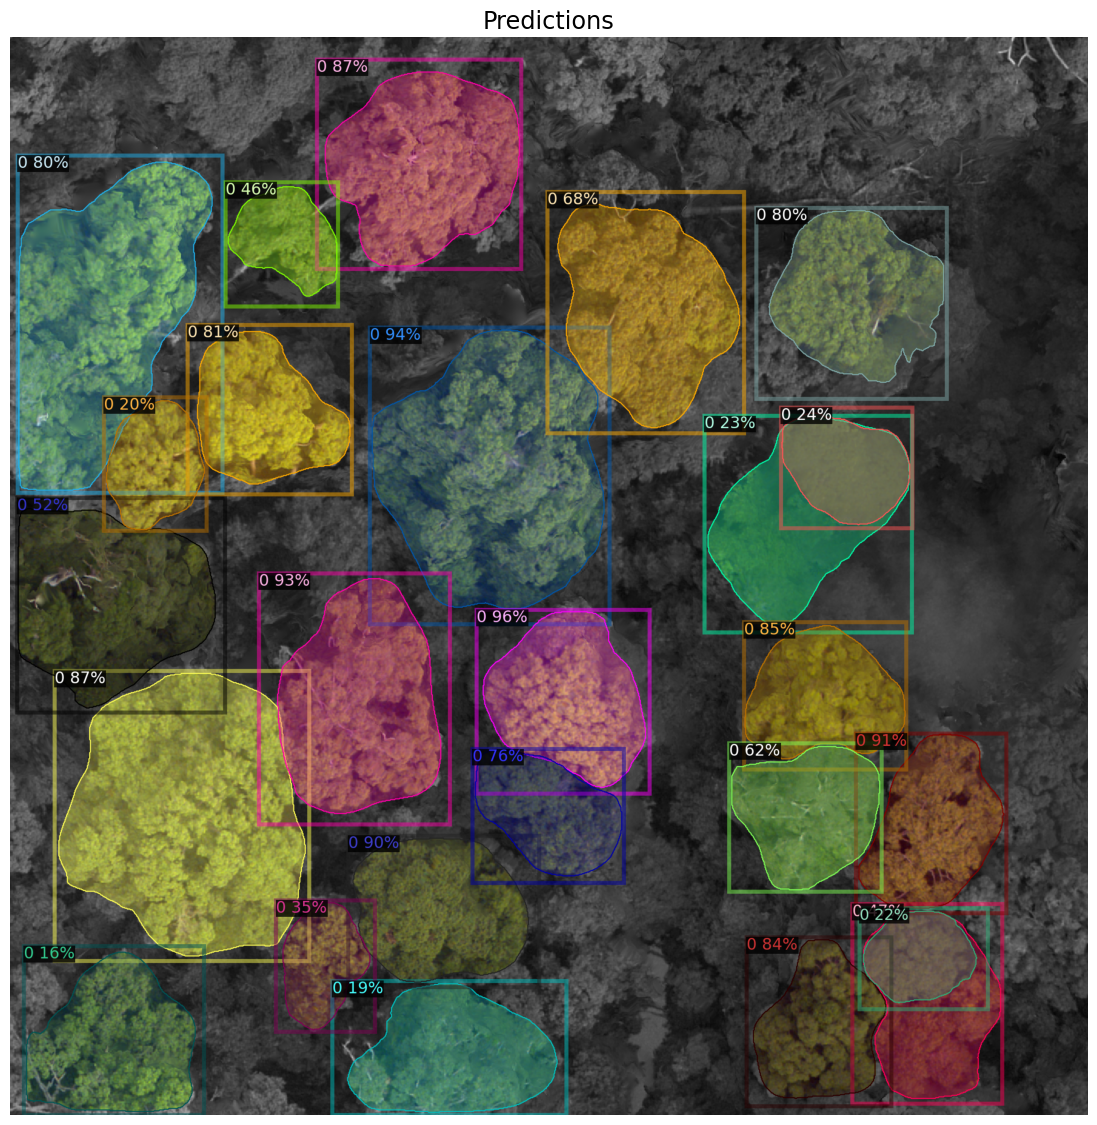

In [12]:
y = model.predict(dataset.sel(band=slice(1,3)), plot=True)